In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Load files

In [2]:
# Load training and testing data
train_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/'
test_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_40min_test/'

train_accel_data = pd.read_csv(train_data_path + 'Combined_accelerometer_100min.csv')
train_gyro_data = pd.read_csv(train_data_path + 'Combined_gyroscope_100min.csv')
train_linear_accel_data = pd.read_csv(train_data_path + 'Combined_linear_accelerometer_100min.csv')
train_magnetometer_data = pd.read_csv(train_data_path + 'Combined_magnetometer_100min.csv')

test_accel_data = pd.read_csv(test_data_path + 'Combined_accelerometer_40min.csv')
test_gyro_data = pd.read_csv(test_data_path + 'Combined_gyroscope_40min.csv')
test_linear_accel_data = pd.read_csv(test_data_path + 'Combined_linear_accelerometer_40min.csv')
test_magnetometer_data = pd.read_csv(test_data_path + 'Combined_magnetometer_40min.csv')

# Combine all data into one dataframe for training and testing
combined_train_data = pd.merge(train_accel_data, train_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_train_data = pd.merge(combined_train_data, train_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_train_data = pd.merge(combined_train_data, train_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

combined_test_data = pd.merge(test_accel_data, test_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_test_data = pd.merge(combined_test_data, test_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_test_data = pd.merge(combined_test_data, test_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))


In [3]:
# Pre-processed sensor data
feature_columns = combined_train_data.columns.difference(['time', 'label'])
X_train_sensor = combined_train_data[feature_columns]
y_train = combined_train_data['label']

X_test_sensor = combined_test_data[feature_columns]
y_test = combined_test_data['label']

# Sensor + Temporal Data

In [4]:
# Sensor + Temporal Data
def add_temporal_features(df, lags, rolling_windows):
    for feature in df.columns:
        if feature not in ['time', 'label']:
            for lag in lags:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in rolling_windows:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()
                df[f'{feature}_ewma'] = df[feature].ewm(span=7).mean()
    df.dropna(inplace=True)
    return df

lags = [3, 5, 7]
rolling_windows = [3, 5, 7]

combined_train_data_temporal = add_temporal_features(combined_train_data.copy(), lags, rolling_windows)
combined_test_data_temporal = add_temporal_features(combined_test_data.copy(), lags, rolling_windows)

feature_columns_temporal = combined_train_data_temporal.columns.difference(['time', 'label'])
X_train_temporal = combined_train_data_temporal[feature_columns_temporal]
y_train_temporal = combined_train_data_temporal['label']

X_test_temporal = combined_test_data_temporal[feature_columns_temporal]
y_test_temporal = combined_test_data_temporal['label']


# Sensor + Fourier Transformations

In [5]:
# Sensor + Fourier Transformations
def compute_fft_features(df, columns):
    fft_features = {}
    for col in columns:
        fft_vals = fft(df[col].values)
        fft_features[f'{col}_fft_real'] = np.real(fft_vals)
        fft_features[f'{col}_fft_imag'] = np.imag(fft_vals)
        fft_features[f'{col}_fft_abs'] = np.abs(fft_vals)
    return pd.DataFrame(fft_features, index=df.index)

fft_columns = combined_train_data.columns.difference(['time', 'label'])
fft_train_data = compute_fft_features(combined_train_data, fft_columns).dropna()
fft_test_data = compute_fft_features(combined_test_data, fft_columns).dropna()

feature_columns_fft = fft_train_data.columns
X_train_fft = fft_train_data
y_train_fft = combined_train_data['label']  # Same labels

X_test_fft = fft_test_data
y_test_fft = combined_test_data['label']  # Same labels

In [6]:

# Sensor + Temporal Features
X_train_sensor_temporal = pd.concat([X_train_sensor, X_train_temporal], axis=1).dropna()
X_test_sensor_temporal = pd.concat([X_test_sensor, X_test_temporal], axis=1).dropna()

y_train_sensor_temporal = y_train.loc[X_train_sensor_temporal.index]
y_test_sensor_temporal = y_test.loc[X_test_sensor_temporal.index]

# Sensor + Fourier Transformations
X_train_sensor_fft = pd.concat([X_train_sensor, X_train_fft], axis=1).dropna()
X_test_sensor_fft = pd.concat([X_test_sensor, X_test_fft], axis=1).dropna()

y_train_sensor_fft = y_train.loc[X_train_sensor_fft.index]
y_test_sensor_fft = y_test.loc[X_test_sensor_fft.index]

# Fourier + Temporal Features
X_train_fourier_temporal = pd.concat([X_train_temporal, X_train_fft], axis=1).dropna()
X_test_fourier_temporal = pd.concat([X_test_temporal, X_test_fft], axis=1).dropna()

y_train_fourier_temporal = y_train.loc[X_train_fourier_temporal.index]
y_test_fourier_temporal = y_test.loc[X_test_fourier_temporal.index]


# Sensor + Temporal + Fourier Features
X_train_all = pd.concat([X_train_sensor, X_train_temporal, X_train_fft], axis=1).dropna()
X_test_all = pd.concat([X_test_sensor, X_test_temporal, X_test_fft], axis=1).dropna()

y_train_all = y_train.loc[X_train_all.index]
y_test_all = y_test.loc[X_test_all.index]


# Train/Test

In [7]:
def plot_feature_importance(rf_model, feature_columns, title):
    feature_importances = rf_model.feature_importances_
    feature_names = feature_columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [8]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, model_params, feature_columns, title):
    rf_model = RandomForestClassifier(**model_params)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['clapping', 'handshake', 'highfive', 'wave'])
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # Plot feature importance
    plot_feature_importance(rf_model, feature_columns, title)
    
    return rf_model

In [9]:
model_params = {
'n_estimators': 150, 
'max_depth': 17, 
'min_samples_split': 9, 
'min_samples_leaf': 1, 
'criterion': 'gini', 
'max_features': 'log2',
'random_state': 24
}

Model 1: Pre-processed Sensor Data
Accuracy: 0.6409
Confusion Matrix:
[[ 909  281    0    0]
 [ 730  338   46   83]
 [  43   13 1020  118]
 [ 346   16   36  788]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.45      0.76      0.56      1190
   handshake       0.52      0.28      0.37      1197
    highfive       0.93      0.85      0.89      1194
        wave       0.80      0.66      0.72      1186

    accuracy                           0.64      4767
   macro avg       0.67      0.64      0.64      4767
weighted avg       0.67      0.64      0.64      4767



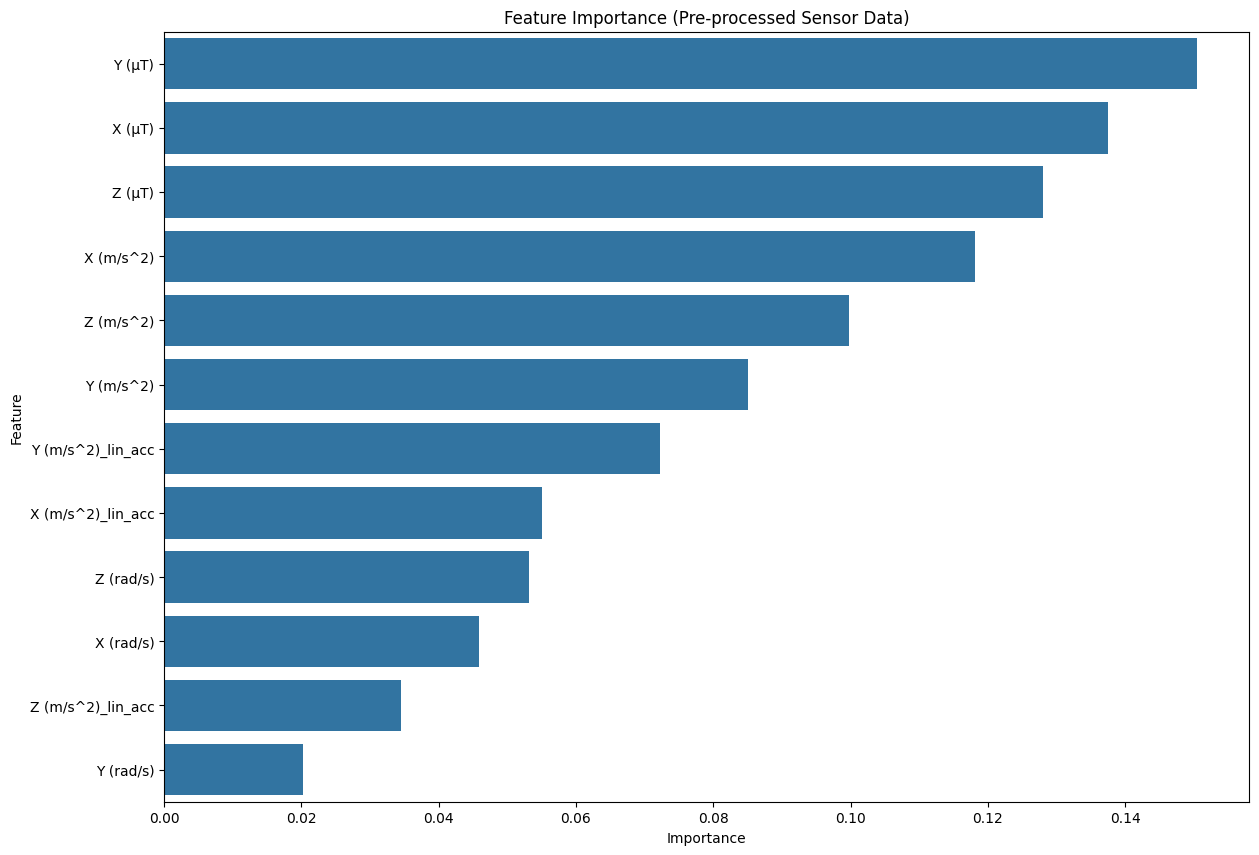

Model 2: Temporal Features Only
Accuracy: 0.7632
Confusion Matrix:
[[1171   15    4    0]
 [ 670  520    0    0]
 [   3    0 1168   23]
 [ 412    0    0  774]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.52      0.98      0.68      1190
   handshake       0.97      0.44      0.60      1190
    highfive       1.00      0.98      0.99      1194
        wave       0.97      0.65      0.78      1186

    accuracy                           0.76      4760
   macro avg       0.86      0.76      0.76      4760
weighted avg       0.86      0.76      0.76      4760



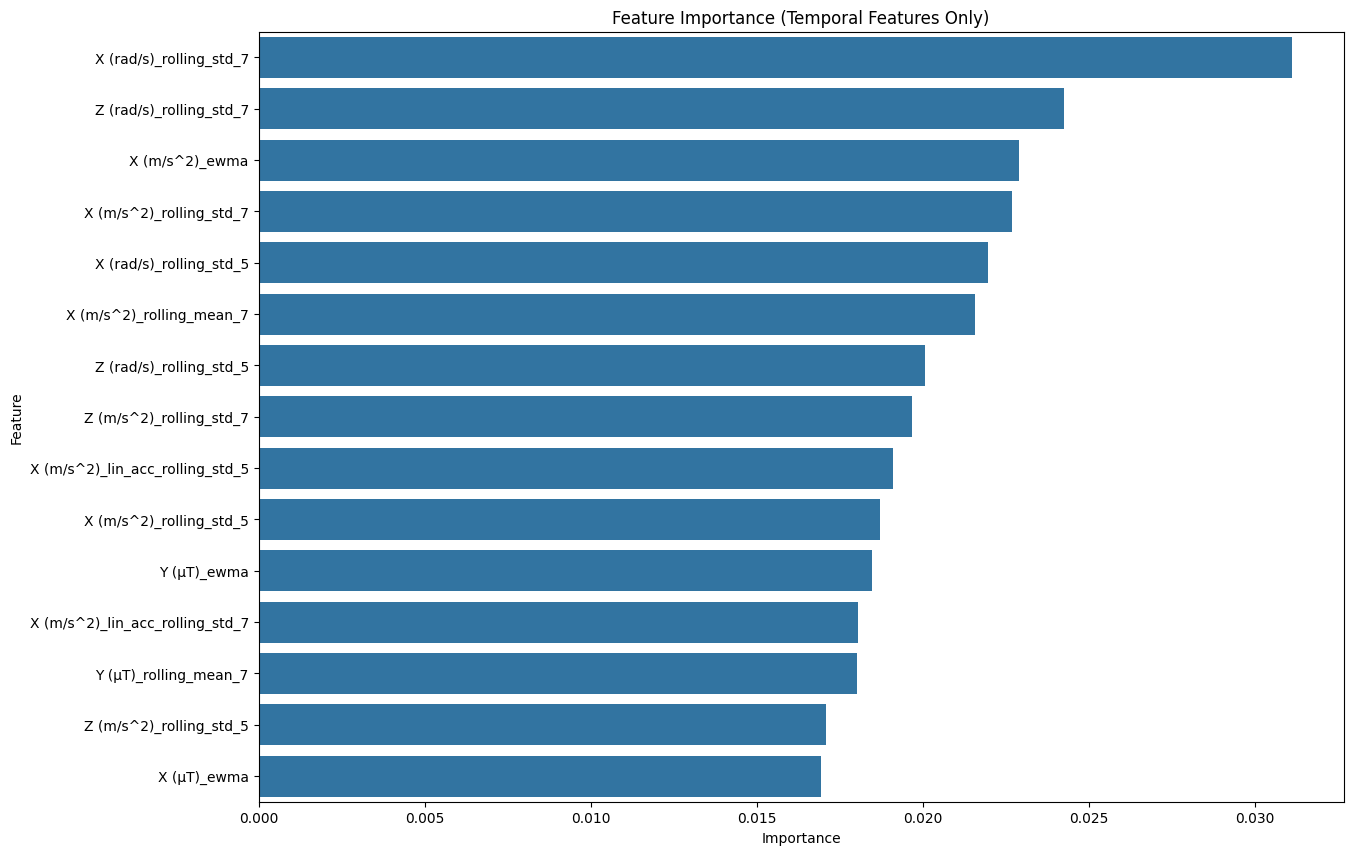

Model 3: Fourier Transformation Only
Accuracy: 0.3690
Confusion Matrix:
[[ 350  631  128   81]
 [   1 1017    1  178]
 [ 326  651  134   83]
 [   4  924    0  258]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.51      0.29      0.37      1190
   handshake       0.32      0.85      0.46      1197
    highfive       0.51      0.11      0.18      1194
        wave       0.43      0.22      0.29      1186

    accuracy                           0.37      4767
   macro avg       0.44      0.37      0.33      4767
weighted avg       0.44      0.37      0.33      4767



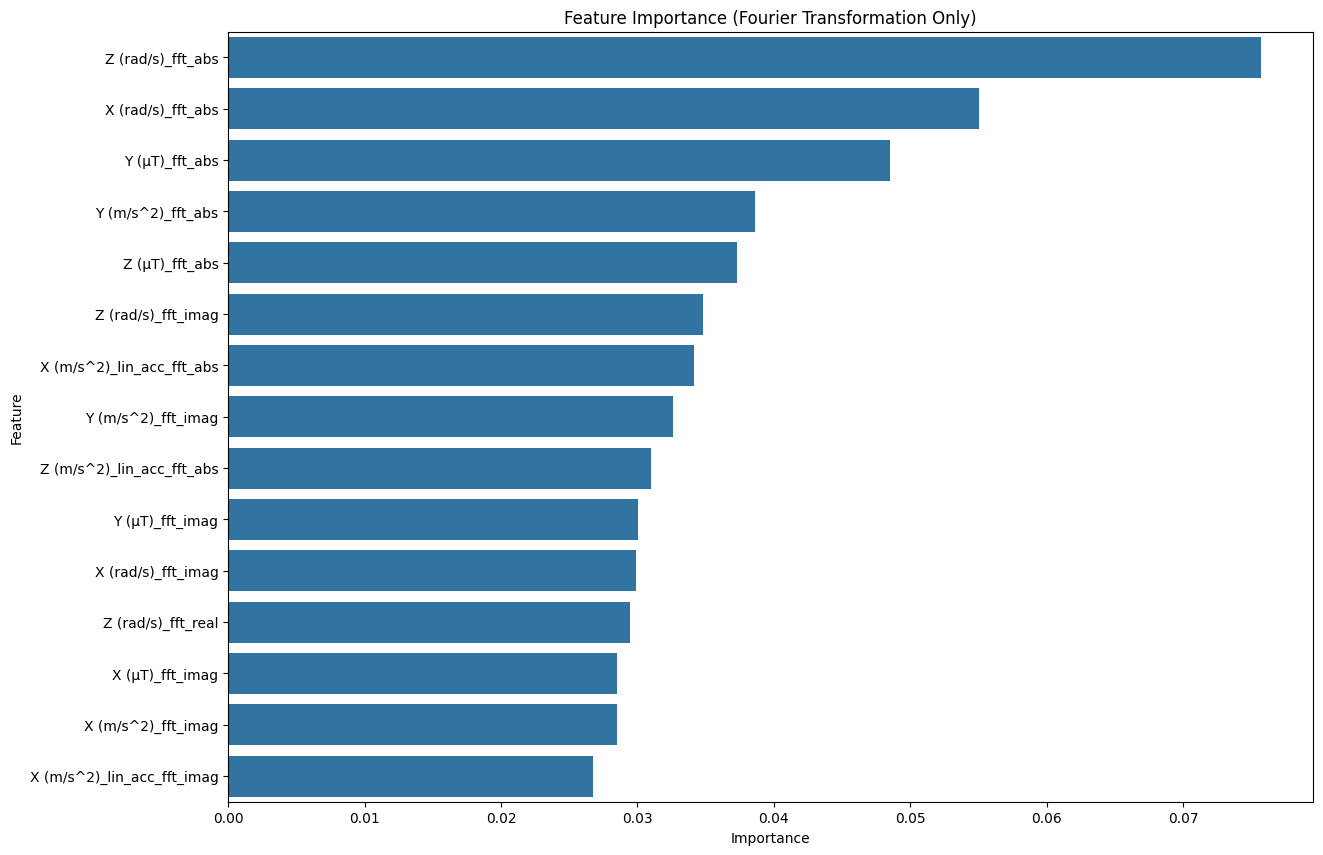

Model 4: Sensor + Temporal Features
Accuracy: 0.7744
Confusion Matrix:
[[1156   30    4    0]
 [ 610  574    6    0]
 [   3    0 1167   24]
 [ 397    0    0  789]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.53      0.97      0.69      1190
   handshake       0.95      0.48      0.64      1190
    highfive       0.99      0.98      0.98      1194
        wave       0.97      0.67      0.79      1186

    accuracy                           0.77      4760
   macro avg       0.86      0.77      0.78      4760
weighted avg       0.86      0.77      0.78      4760



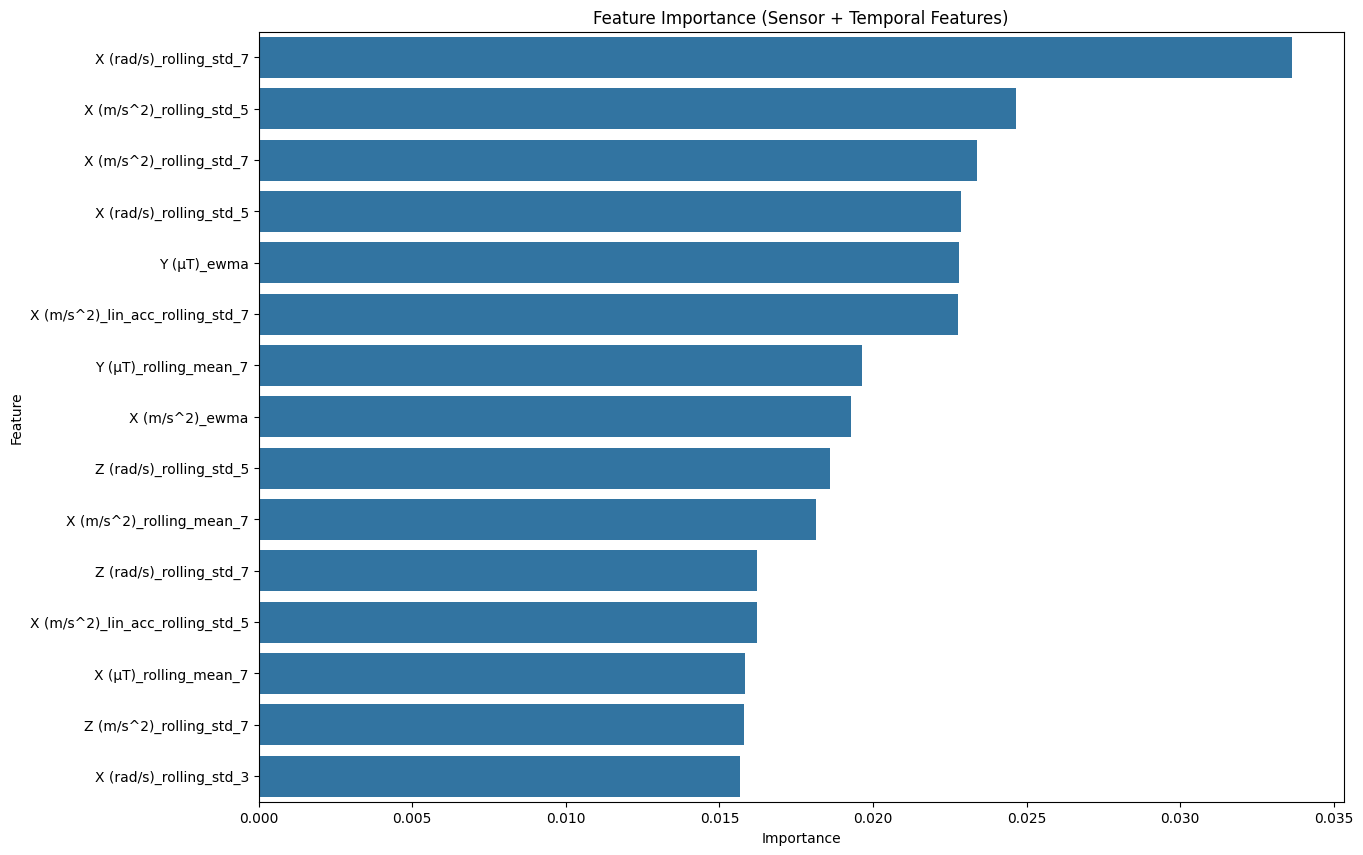

Model 5: Sensor + Fourier Transformations
Accuracy: 0.6826
Confusion Matrix:
[[968 218   0   4]
 [520 575  64  38]
 [ 60  35 894 205]
 [335  34   0 817]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.51      0.81      0.63      1190
   handshake       0.67      0.48      0.56      1197
    highfive       0.93      0.75      0.83      1194
        wave       0.77      0.69      0.73      1186

    accuracy                           0.68      4767
   macro avg       0.72      0.68      0.69      4767
weighted avg       0.72      0.68      0.69      4767



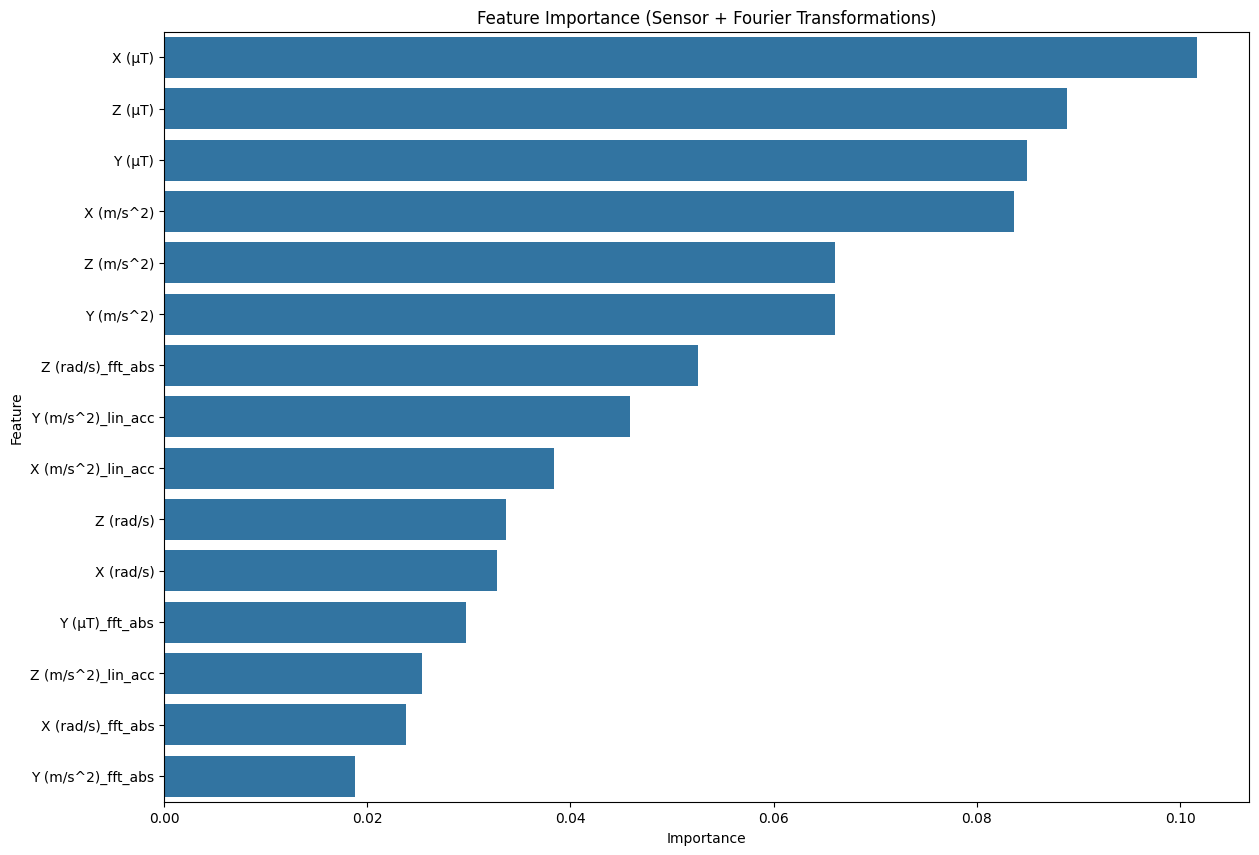

Model 6: Sensor + Temporal + Fourier Features
Accuracy: 0.7347
Confusion Matrix:
[[1088   98    4    0]
 [ 727  459    4    0]
 [   1    0 1171   22]
 [ 407    0    0  779]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.49      0.91      0.64      1190
   handshake       0.82      0.39      0.53      1190
    highfive       0.99      0.98      0.99      1194
        wave       0.97      0.66      0.78      1186

    accuracy                           0.73      4760
   macro avg       0.82      0.73      0.73      4760
weighted avg       0.82      0.73      0.73      4760



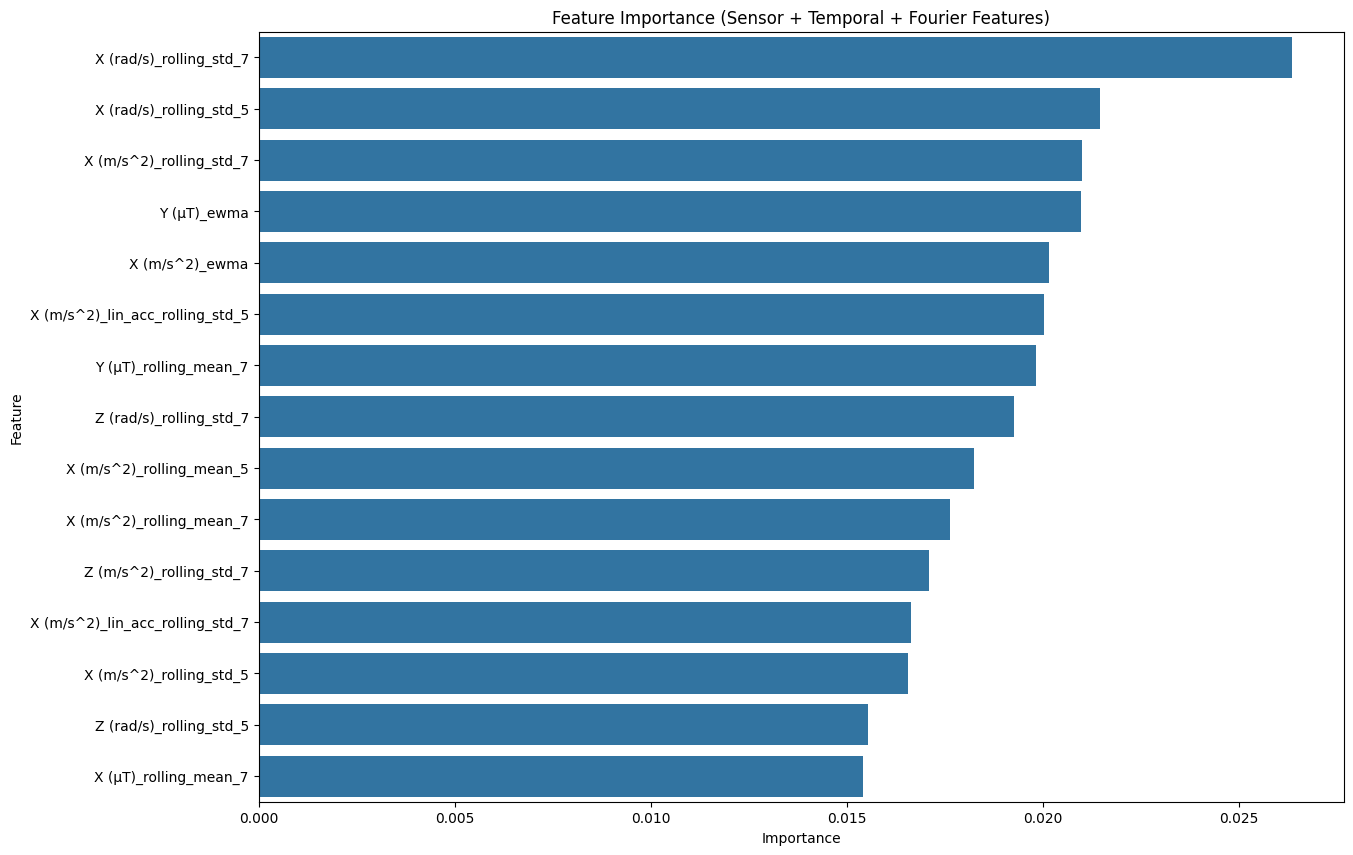

Model 7: Fourier + Temporal Features
Accuracy: 0.7239
Confusion Matrix:
[[1106   80    4    0]
 [ 811  378    1    0]
 [   3    0 1173   18]
 [ 397    0    0  789]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.48      0.93      0.63      1190
   handshake       0.83      0.32      0.46      1190
    highfive       1.00      0.98      0.99      1194
        wave       0.98      0.67      0.79      1186

    accuracy                           0.72      4760
   macro avg       0.82      0.72      0.72      4760
weighted avg       0.82      0.72      0.72      4760



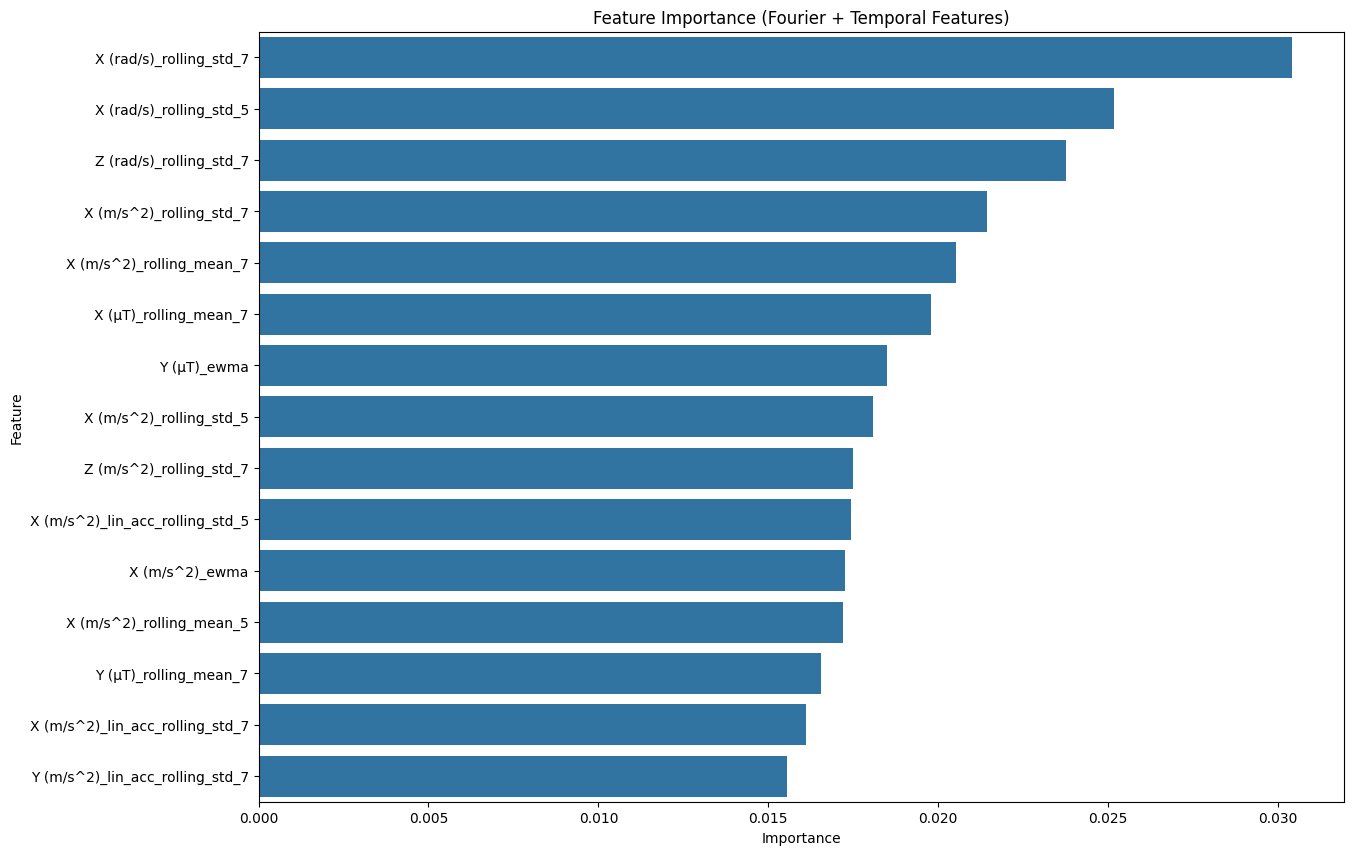

In [10]:
# Model 1: Pre-processed Sensor Data
print("Model 1: Pre-processed Sensor Data")
rf_model_sensor = train_and_evaluate_rf(X_train_sensor, y_train, X_test_sensor, y_test, model_params, feature_columns, "Feature Importance (Pre-processed Sensor Data)")

# Model 2: Temporal Features Only
print("Model 2: Temporal Features Only")
rf_model_temporal_only = train_and_evaluate_rf(X_train_temporal, y_train_temporal, X_test_temporal, y_test_temporal, model_params, feature_columns_temporal, "Feature Importance (Temporal Features Only)")

# Model 3: Fourier Transformation Only
print("Model 3: Fourier Transformation Only")
rf_model_fft_only = train_and_evaluate_rf(X_train_fft, y_train_fft, X_test_fft, y_test_fft, model_params, feature_columns_fft, "Feature Importance (Fourier Transformation Only)")

# Model 4: Sensor + Temporal Features
print("Model 4: Sensor + Temporal Features")
rf_model_sensor_temporal = train_and_evaluate_rf(X_train_sensor_temporal, y_train_sensor_temporal, X_test_sensor_temporal, y_test_sensor_temporal, model_params, X_train_sensor_temporal.columns, "Feature Importance (Sensor + Temporal Features)")

# Model 5: Sensor + Fourier Transformations
print("Model 5: Sensor + Fourier Transformations")
rf_model_sensor_fft = train_and_evaluate_rf(X_train_sensor_fft, y_train_sensor_fft, X_test_sensor_fft, y_test_sensor_fft, model_params, X_train_sensor_fft.columns, "Feature Importance (Sensor + Fourier Transformations)")

# Model 6: Sensor + Temporal + Fourier Features
print("Model 6: Sensor + Temporal + Fourier Features")
rf_model_all = train_and_evaluate_rf(X_train_all, y_train_all, X_test_all, y_test_all, model_params, X_train_all.columns, "Feature Importance (Sensor + Temporal + Fourier Features)")

# Model 7: Fourier + Temporal Features
print("Model 7: Fourier + Temporal Features")
rf_model_fourier_temporal = train_and_evaluate_rf(X_train_fourier_temporal, y_train_fourier_temporal, X_test_fourier_temporal, y_test_fourier_temporal, model_params, X_train_fourier_temporal.columns, "Feature Importance (Fourier + Temporal Features)")
